In [407]:
# Package imports
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

import torch
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline


In [408]:
lines = []  # create an empty list to store the lines

with open('dinos.txt', 'r') as file:
    for line in file:
        lines.append(line.strip().lower())  # append each line to the list after removing whitespace

maxlen = len(max(lines, key=len))
num_lines = len(lines)
#print("The longest dino name:", maxlen)
#print("Num lines:", len(lines))

chars = list(string.ascii_lowercase) + list('.')
vocab_size = len(chars)

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
#print(char_to_ix)

In [394]:
# Parameters and Hyperparameters
input_dim = vocab_size
hidden_dim = 32
output_dim = vocab_size #ie 27
n_layers = 1
batch_len = 10
seq_len = maxlen   #ie 26 

# Training set and labels
X = torch.empty(0, dtype=torch.long)
Y = torch.empty(0, dtype=torch.long)

for line in lines:
    
    namelen = len(line)

    #convert to chars in line to ints
    xidvec = torch.tensor( [ char_to_ix[char] for char in line], dtype=torch.long )
    # pad with '.' to fill 
    pad = "."*(seq_len-namelen)
    padvec = torch.tensor( [ char_to_ix[char] for char in pad], dtype=torch.long )
    xidvec = torch.cat((xidvec, padvec), dim=0)
    #print(xidvec)
    
    #y should be x left shifted one step, and then add a '.' at the end
    yidvec = torch.tensor(xidvec[1:].tolist() , dtype=torch.long)
    yidvec = torch.cat( (yidvec, torch.tensor([26], dtype=torch.long)), dim=0)
    #print(yidvec)
    
    #Encode to one hot
    xonehot = F.one_hot(xidvec, vocab_size).type(torch.long)
    yonehot = F.one_hot(yidvec, vocab_size).type(torch.long)
    
    #Add this word to the training set X and labels Y
    X = torch.cat((X, xonehot), dim=0)
    Y = torch.cat((Y, yonehot), dim=0)
    
print('X shape:', X.shape)
print('Y shape:', Y.shape)
    
#Reshape it to feed to the dataset
X = X.reshape((-1, seq_len, vocab_size)).float()
Y = Y.reshape((-1, seq_len, vocab_size)).float()
print('Reshaped X shape:', X.shape)
print('Reshapedd Y shape:', Y.shape)
    
# Wrap the tensors in a TensorDataset
dataset = TensorDataset(X, Y)

# Create a DataLoader 
dataloader = DataLoader(dataset, batch_size=batch_len, shuffle=True)

Count: 1536
X shape: torch.Size([39936, 27])
Y shape: torch.Size([39936, 27])
Reshaped X shape: torch.Size([1536, 26, 27])
Reshapedd Y shape: torch.Size([1536, 26, 27])


DinosNN(
  (RNN): RNN(27, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=27, bias=True)
  (Softmax): Softmax(dim=1)
)
Loss: 2.92813777923584
Loss: 2.588542938232422
Loss: 2.5499463081359863
Loss: 2.665745258331299
Loss: 2.568744659423828
Loss: 2.529308557510376
Loss: 2.5214433670043945
Loss: 2.549121379852295
Loss: 2.569563150405884
Loss: 2.557523250579834
tensor([[2.78e-09, 8.35e-10, 2.19e-09,  ..., 1.37e-09, 6.88e-10, 1.88e-12],
        [1.00e+00, 2.27e-14, 2.42e-14,  ..., 3.91e-14, 1.76e-14, 2.30e-13],
        [9.99e-01, 3.12e-09, 6.94e-09,  ..., 4.85e-09, 3.10e-09, 1.59e-10],
        ...,
        [9.25e-16, 8.44e-15, 1.03e-14,  ..., 2.94e-14, 9.67e-15, 1.00e+00],
        [9.41e-16, 8.63e-15, 1.06e-14,  ..., 3.01e-14, 9.90e-15, 1.00e+00],
        [9.70e-16, 8.52e-15, 1.04e-14,  ..., 2.97e-14, 9.77e-15, 1.00e+00]],
       grad_fn=<SoftmaxBackward0>)


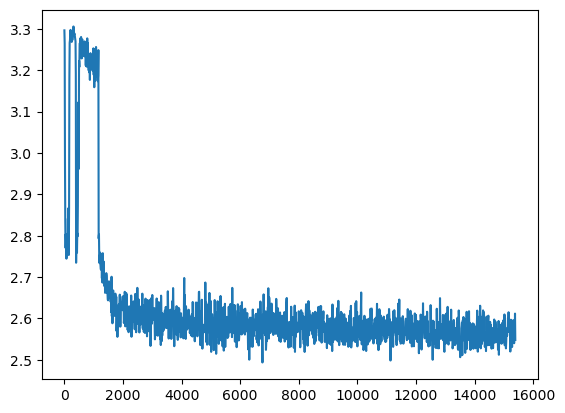

In [409]:

#Define the Class
class DinosNN(nn.Module):

        def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
            super(DinosNN, self).__init__()
            self.hidden_dim = hidden_dim
            self.RNN = nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)
            self.Softmax = nn.Softmax(dim=1)

        def forward(self, x, hidden):
            out, hidden = self.RNN(x, hidden)
            #Should be: batch_size, seq_len, hidden_dim (1, 26, 32)
            
            out = out.reshape( -1, self.hidden_dim)
            # Should be batchsize*seq_length, hidden dim [26, 32]
            
            out = self.fc(out)
            out = self.Softmax(out)
            
            return out, hidden
            

# Initialize the model and define the loss function and optimizer
dinomodel = DinosNN(input_dim, hidden_dim, vocab_size, n_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dinomodel.parameters(), lr=0.001)

print(dinomodel)

numepochs =100

lossi=[]
stepi=[]
step=0


for n in range(numepochs):
    #print("Epoch;", n)


    for i, (inputs, labels) in enumerate(dataloader):
        hidden = None

        yout, hidden = dinomodel(inputs, hidden)
        hidden = hidden.data

        labels=labels.reshape(-1, vocab_size)
        loss = criterion(yout, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if(step%10==0):
            stepi.append(step)
            lossi.append(loss.item())
        step+=1
        
    if(n%10 == 0):
        print("Loss:", loss.item())

print(yout)

plt.plot(stepi,lossi)

In [371]:
#Generate some dino names
import string

inp = torch.zeros(seq_len, dtype=torch.long)
inphot = F.one_hot(inp, vocab_size).type(torch.float)

hidden = None
output, hidden = dinomodel(inphot, hidden)

probs = output[0].detach().numpy()
print(probs.shape)
print(probs)

next_char = np.random.choice(chars, p=probs)
print("next:", next_char)


Inphot shape: torch.Size([26, 27])
torch.Size([26, 27])
['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
(27,)
[0.39420307 0.06840007 0.01611208 0.01753766 0.02207042 0.02097939
 0.01910058 0.01838383 0.01267004 0.01903852 0.01340396 0.0115588
 0.0138196  0.01749516 0.01874528 0.05264522 0.0128767  0.01668368
 0.08074021 0.02911348 0.0178015  0.04515052 0.01006527 0.009281
 0.01334139 0.01779931 0.01098326]
picking
next: 

